Shape of observations: (4000, 1000, 37)
Number of runs: 1000
Number of full runs: 415
Percentage of full runs: 41.50%
Payload shape: (4000, 1000, 3)
Payload velocity shape: (4000, 1000, 3)
Other quads shape: (4000, 1000, 3)
q_pos shape: (4000, 1000, 3)
q_rot_mat shape: (4000, 1000, 9)
q_linvel shape: (4000, 1000, 3)
q_angvel shape: (4000, 1000, 3)
q_linacc shape: (4000, 1000, 3)
q_angacc shape: (4000, 1000, 3)
q_last_action shape: (4000, 1000, 3)
Payload shape (timesteps, runs, dims): (4000, 1000, 3)


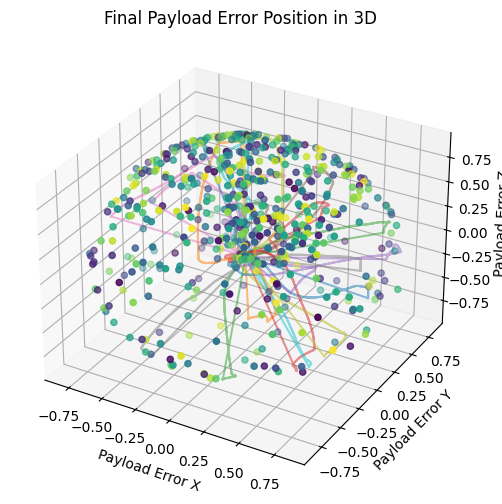

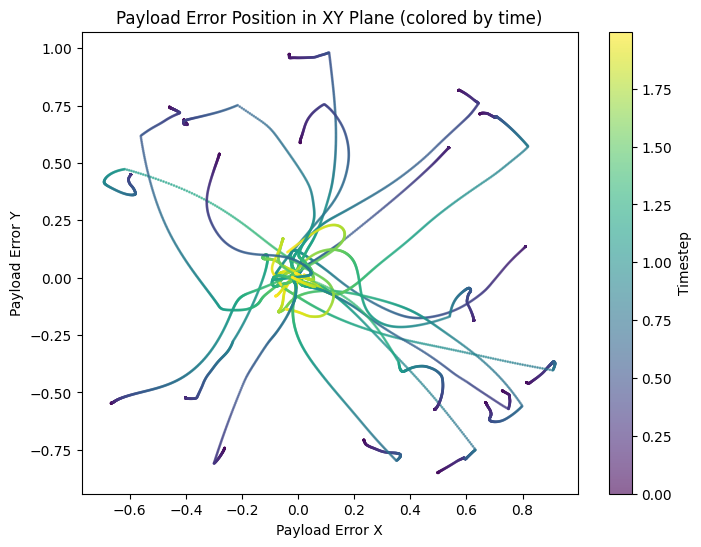

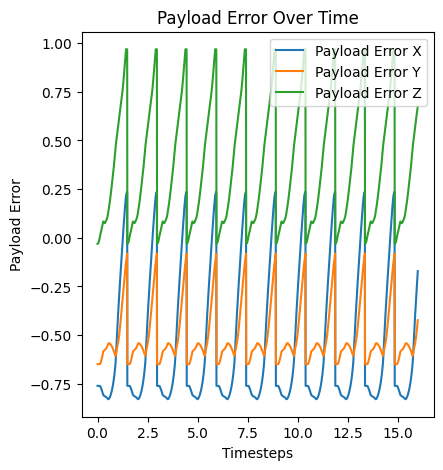

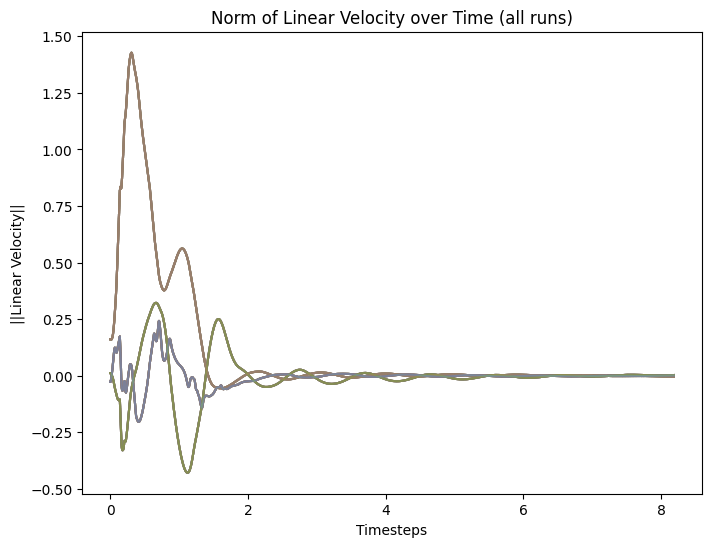

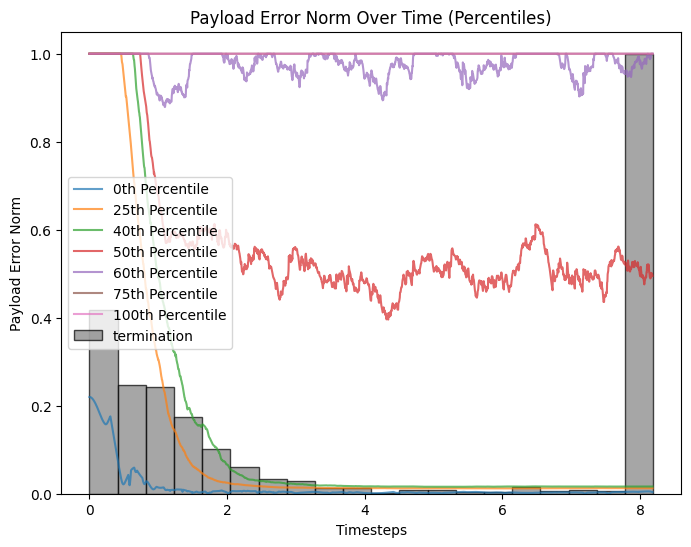

In [112]:
import asdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

# Path to your ASDF file
file_path = 'flights.crazy.asdf'

# Load the ASDF file and read the observations into memory
with asdf.open(file_path) as af:
    obs = np.array(af['flights'][0]['agents']['agent_1']['observations'])
    dones = np.array(af['flights'][0]['global']['dones'])
    dt = af['flights'][0]['metadata']['dt']


print("Shape of observations:", obs.shape)



num_runs = 20
#count dones
num_dones = np.sum(dones[0, :])
print(f"Number of runs: {obs.shape[1]}")




# find index of first done
first_dones = np.argmax(dones,axis=0)

full_runs = np.where(first_dones > 2000)[0]
failed_runs = np.where(first_dones <= 2000)[0]


print(f"Number of full runs: {full_runs.shape[0]}")
# print percentage of runs that are full
percentage_full_runs = full_runs.shape[0] / obs.shape[1] *100
print(f"Percentage of full runs: {percentage_full_runs:.2f}%")



#Dynamic ix4 mapping: {'agent_0': [(0, 2), (3, 5), (30, 32), (6, 29), (54, 57)], 'agent_1': [(0, 2), (3, 5), (6, 8), (30, 53), (58, 61)]}
# Extract payload error (X, Y, Z) for the first num_runs environments
timesteps = obs.shape[0]
time = np.arange(timesteps) * dt
payload = obs[:, :, 0:3]  # shape (timesteps, , 3)
payload_velocity = obs[:, :, 3:6]  # shape (timesteps, , 3)
other_quads = obs[:, :, 6:9]  # shape (timesteps, , 3)

#obs_list = [payload_error, payload_linvel, rel, rot, linvel, angvel, linear_acc, angular_acc]
q_pos = obs[:, :, 9:12]  # shape (timesteps, , 3)
q_rot_mat = obs[:, :, 12:21]  # shape (timesteps, , 9)
q_linvel = obs[:, :, 21:24]  # shape (timesteps, , 3)
q_angvel = obs[:, :, 24:27]  # shape (
q_linacc = obs[:, :, 27:30]  # shape (timesteps, , 3)
q_angacc = obs[:, :, 30:33]  # shape (timesteps, , 3)
q_last_action = obs[:, :, 33:36]  # shape (timesteps, num_runs, 3)




print("Payload shape:", payload.shape)
print("Payload velocity shape:", payload_velocity.shape)
print("Other quads shape:", other_quads.shape)
print("q_pos shape:", q_pos.shape)
print("q_rot_mat shape:", q_rot_mat.shape)
print("q_linvel shape:", q_linvel.shape)
print("q_angvel shape:", q_angvel.shape)
print("q_linacc shape:", q_linacc.shape)
print("q_angacc shape:", q_angacc.shape)
print("q_last_action shape:", q_last_action.shape)  




# Create 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

print(f"Payload shape (timesteps, runs, dims): {payload.shape}")

# Plot final positions in 3D
final_pos = payload[-1]
xs, ys, zs = final_pos[:, 0], final_pos[:, 1], final_pos[:, 2]
ax.scatter(xs, ys, zs, c=range(final_pos.shape[0]), cmap='viridis', depthshade=True)

# render path
for run in range(num_runs):
    path = payload[:, full_runs[run] , :]  # Extract the path for each run
    ax.plot(path[:, 0], path[:, 1], path[:, 2], alpha=0.5)  # Plot the path
# Set limits for better visualization
ax.set_xlim([np.min(xs), np.max(xs)])
ax.set_ylim([np.min(ys), np.max(ys)])
ax.set_zlim([np.min(zs), np.max(zs)])

# Labels and title
ax.set_xlabel('Payload Error X')
ax.set_ylabel('Payload Error Y')
ax.set_zlabel('Payload Error Z')
ax.set_title('Final Payload Error Position in 3D')

# plot only in xy plane with color based on time
fig2, ax2 = plt.subplots(figsize=(8, 6))

for run in range(num_runs):
    path = payload[:500, full_runs[run], :]
    sc = ax2.scatter(path[:, 0], path[:, 1],
                     c=time[:500],
                     cmap='viridis',
                     s=1,         # smaller point size
                     alpha=0.6)
ax2.set_xlabel('Payload Error X')
ax2.set_ylabel('Payload Error Y')
ax2.set_title('Payload Error Position in XY Plane (colored by time)')
cbar = fig2.colorbar(sc, ax=ax2)
cbar.set_label('Timestep')
# Show the plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time, payload[:, 0, 0], label='Payload Error X')
plt.plot(time, payload[:, 0, 1], label='Payload Error Y')
plt.plot(time, payload[:, 0, 2], label='Payload Error Z')
plt.xlabel('Timesteps')
plt.ylabel('Payload Error')
plt.title('Payload Error Over Time')
plt.legend()

# Compute the norm of linear velocity at each timestep for each run
linvel_norm = np.linalg.norm(q_linvel, axis=2)  # shape (timesteps, num_runs)

# Plot all runs
fig3, ax3 = plt.subplots(figsize=(8, 6))
for r in range(num_runs):
    end = first_dones[2]
    linvel_norm = np.linalg.norm(q_linvel[:end,2,:], axis=1)
    ax3.plot(time[:end], q_linvel[:end,2,:], alpha=0.3)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('||Linear Velocity||')
ax3.set_title('Norm of Linear Velocity over Time (all runs)')
plt.show()

# plot showing the norm of payload error over time
# show the percentiles of runs
fig4, ax4 = plt.subplots(figsize=(8, 6))
percentiles = [0, 25, 40, 50, 60,  75, 100]
p_error_norm = np.linalg.norm(payload[:2046, : , :], axis=2)  # shape (timesteps, num_runs)
for p in percentiles:
    p_val = np.percentile(p_error_norm, p, axis=1)
    ax4.plot(time[:2046], p_val, label=f'{p}th Percentile', alpha=0.7)
ax4.set_xlabel('Timesteps')
ax4.set_ylabel('Payload Error Norm')
ax4.set_title('Payload Error Norm Over Time (Percentiles)')
 
# crate a line plot of the first dones over time

first_dones_hist, bins = np.histogram(first_dones*dt, bins=20)
ax4.bar(bins[:-1], first_dones_hist/np.max(first_dones_hist), width=np.diff(bins), align='edge', alpha=0.7, label='termination', color='gray', edgecolor='black')

ax4.legend()   


dones [[ 0.23651265 -0.08175635  0.9681826 ]
 [-0.16772872 -0.1387143   0.90486073]
 [-0.3801297  -0.90198106  0.20477207]
 [ 0.81885093 -0.56163186  0.11854451]
 [-0.21359318  0.38826314  0.8964539 ]
 [-0.01398455 -0.08159228  0.30510926]
 [ 0.48189852  0.47117835  0.7387589 ]
 [ 0.53101116 -0.1464375   0.80058956]
 [-0.05674384 -0.08298096  0.9949343 ]
 [ 0.12960835  0.5212062   0.84353167]]


Text(0.5, 0.92, 'Start Positions of Payload and Other Quads in 3D')

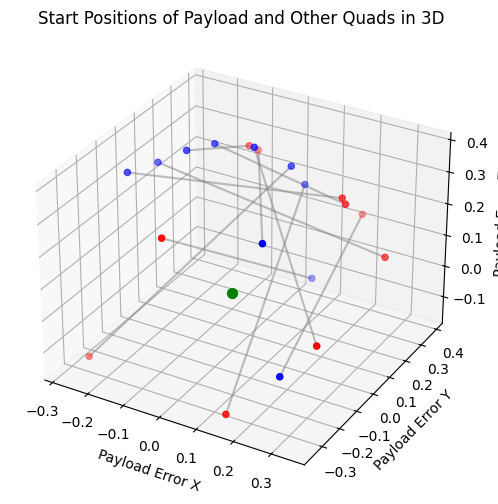

In [114]:
#plot the start pos q_pos and other quad as a connected line in 3D
fig5 = plt.figure(figsize=(8, 6))
ax5 = fig5.add_subplot(111, projection='3d')    
# Plot start positions of payload and other quads
runs_to_plot = failed_runs[:10]
start_payload = q_pos[first_dones[runs_to_plot], runs_to_plot, :]
start_other_quads = other_quads[first_dones[runs_to_plot], runs_to_plot, :]

print("dones", payload[first_dones[runs_to_plot], runs_to_plot, :])
ax5.scatter(start_payload[:, 0], start_payload[:, 1], start_payload[:, 2], c='blue', label='Start Payload', depthshade=True)
ax5.scatter(start_other_quads[:, 0], start_other_quads[:, 1], start_other_quads[:, 2], c='red', label='Start Other Quads', depthshade=True)
# Connect the start positions with lines
for run in range(10):
    payload_start = start_payload[run]
    other_quad_start = start_other_quads[run]
    ax5.plot([payload_start[0], other_quad_start[0]],
             [payload_start[1], other_quad_start[1]],
             [payload_start[2], other_quad_start[2]], c='gray', alpha=0.5)

#mark 0,0 in green
ax5.scatter(0, 0, 0, c='green', s=50, label='Origin (0,0,0)', depthshade=True)


# Labels and title
ax5.set_xlabel('Payload Error X')
ax5.set_ylabel('Payload Error Y')
ax5.set_zlabel('Payload Error Z')
ax5.set_title('Start Positions of Payload and Other Quads in 3D')

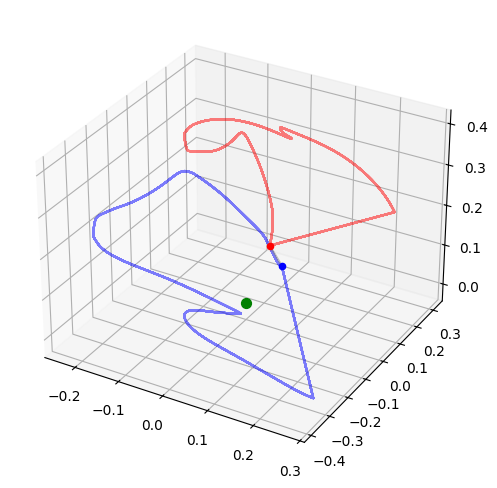

In [111]:
# plot payload pos q_pos and other quad over time in 3D. Mark the pos at the first timestep with dots connected by q_pos->payload and other_quads->payload
fig6 = plt.figure(figsize=(8, 6))
ax6 = fig6.add_subplot(111, projection='3d')
# Plot the trajectory of payload and other quads over time
for run in range(1):
    payload_path = q_pos[:, failed_runs[run], :]
    other_quads_path = other_quads[:, failed_runs[run], :]
    ax6.plot(payload_path[:, 0], payload_path[:, 1], payload_path[:, 2], c='blue', alpha=0.5, label='Payload Path' if run == 0 else "")
    ax6.plot(other_quads_path[:, 0], other_quads_path[:, 1], other_quads_path[:, 2], c='red', alpha=0.5, label='Other Quads Path' if run == 0 else "")
    
    # Mark the first position with a dot
    ax6.scatter(payload_path[0, 0], payload_path[0, 1], payload_path[0, 2], c='blue', s=20)
    ax6.scatter(other_quads_path[0, 0], other_quads_path[0, 1], other_quads_path[0, 2], c='red', s=20)
# Connect the first positions with a line
    ax6.plot([payload_path[0, 0], other_quads_path[0, 0]],
                [payload_path[0, 1], other_quads_path[0, 1]],
                [payload_path[0, 2], other_quads_path[0, 2]], c='gray', alpha=0.5)
# Mark 0,0 in green
ax6.scatter(0, 0, 0, c='green', s=50, label='Origin (0,0,0)', depthshade=True)
